In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib

In [7]:
data_dir = pathlib.Path('Dataset/Train')
batch_size = 32
img_height = 100
img_width = 100


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)


Found 23407 files belonging to 5 classes.
Using 18726 files for training.
Found 23407 files belonging to 5 classes.
Using 4681 files for validation.
['Apples', 'Cherries', 'Grapes', 'Pear', 'Tomatoes']


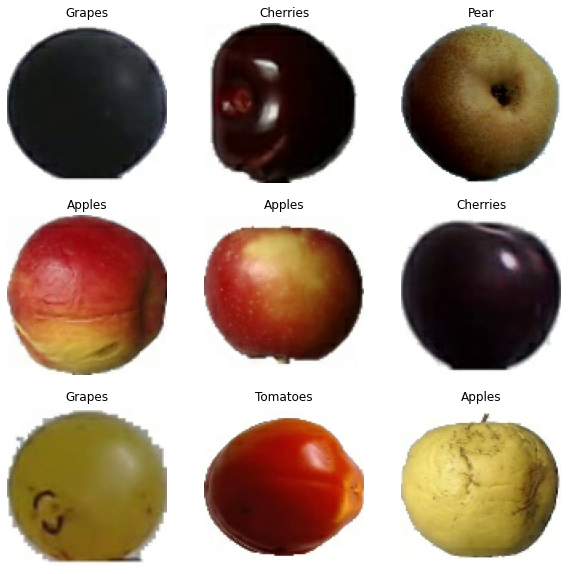

In [10]:
def plot_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
plot_images()